In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Генерируем матрицу признаков и вектор целей для задачи классификации
X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           n_classes=2,
                           class_sep=2,
                           random_state=1)

In [3]:
# Выведем первые пять строк X
print(pd.DataFrame(X).head())

          0         1
0  1.863411  0.087646
1 -1.530997  1.901182
2 -0.017224 -2.591112
3 -2.032039 -1.801162
4  4.620555  0.901124


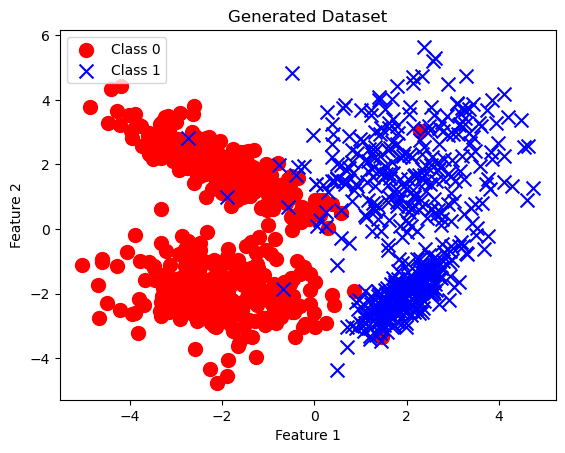

In [7]:
# Построим график для визуализации данных
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], marker="o", c='r', s=100, label='Class 0')
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], marker="x", c='b', s=100, label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Dataset')
plt.legend()
plt.show()

In [9]:
# Реализация градиентного спуска
class SGD:
    def __init__(self, alpha=0.5, n_iters=1000):
        self.b = None
        self._alpha = alpha
        self._n_iters = n_iters

    def gradient_step(self, b, b_grad):
        return b - self._alpha * b_grad

    def optimize(self, X, y, start_b, n_iters):
        b = start_b.copy()
        for i in range(n_iters):
            b_grad = self.grad_func(X, y, b)
            b = self.gradient_step(b, b_grad)
        return b

In [11]:
# Реализация логистической регрессии
class LogReg(SGD):
    def sigmoid(self, X, b):
        return 1. / (1. + np.exp(-X.dot(b)))

    def grad_func(self, X, y, b):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, b) - y)
        return grad

    def fit(self, X, y):
        m = X.shape[1]
        start_b = np.zeros(m)
        self.b = self.optimize(X, y, start_b, self._n_iters)

    def predict_proba(self, X):
        return self.sigmoid(X, self.b)

    def predict(self, X):
        y_pred = self.predict_proba(X) > 0.5
        return y_pred.astype(int)

In [13]:
# Добавляем фиктивный столбец единиц к матрице признаков
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

In [15]:
# Создаем и обучаем модель логистической регрессии
logreg = LogReg(alpha=0.1, n_iters=1000)
logreg.fit(X, y)

In [17]:
# Делаем предсказание и вычисляем метрики качества
y_pred = logreg.predict(X)
ac = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
print(f'Accuracy = {ac:.2f} F1-score = {f1:.2f}')

Accuracy = 0.98 F1-score = 0.98


In [19]:
# Выводим значения вероятностей для каждого объекта принадлежать тому или иному классу
y_pred_proba = logreg.predict_proba(X)

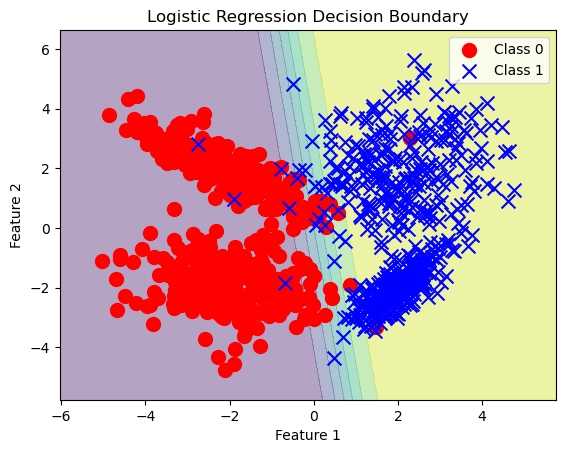

In [21]:
# Построим график разделяющей границы
xx, yy = np.meshgrid(
    np.arange(X.min(axis=0)[1] - 1, X.max(axis=0)[1] + 1, 0.01), 
    np.arange(X.min(axis=0)[2] - 1, X.max(axis=0)[2] + 1, 0.01))
XX = np.array(list(zip(xx.ravel(), yy.ravel()))).reshape((-1, 2))
XX = np.array([(1, *xx) for xx in XX])

Z = logreg.predict_proba(XX)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 1][y == 0], X[:, 2][y == 0], marker="o", c='r', s=100, label='Class 0')
plt.scatter(X[:, 1][y == 1], X[:, 2][y == 1], marker="x", c='b', s=100, label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()

In [23]:
# Проверка работы библиотечной модели
model = LogisticRegression()
model.fit(X[:, 1:], y)  # Используем только признаковые столбцы без фиктивного
y_pred_lr = model.predict(X[:, 1:])
ac_lr = accuracy_score(y, y_pred_lr)
f1_lr = f1_score(y, y_pred_lr)
print(f'Library Accuracy = {ac_lr:.2f} Library F1-score = {f1_lr:.2f}')

Library Accuracy = 0.98 Library F1-score = 0.98
